# Autoencoders

I've been exploring how useful [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) are and how painfully simple they are to implement in [Keras](https://keras.io/). In this post, my goal is to better understand them myself, so I borrow heavily from [the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html) on the same topic. So rather than sprinkling references to the Keras blog throughout the post, just assume I borrowed it from [Francois Chollet](https://twitter.com/fchollet). Thanks to Francois for making his code available!

For instance, I thought about drawing a diagram overviewing autoencoders, but it's hard to beat the effective simplicity of this diagram.

![stole from Keras blog](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

So, autoencoders are legit. They perform data compression but not in the JPEG or MPEG way, which make some broad assumptions about images, sound, and video and apply compression based on the assumptions. Instead, autoencoders **learn** (automatically) a lossy compression based on the data examples fed in. So the compression is specific to those examples.

## What's Required

Autoencoders require 3 things:

1. Encoding function
2. Decoding function
3. Loss function describing the amount of information loss between the compressed and decompressed representations of the data examples and the decompressed representation (i.e. a "loss" function).

The encoding/decoding functions are typically (parametric) neural nets and are differentiable with respect to the distance function. The differentiable part enables optimizing the parameters of the encoding/decoding functions to minimize the reconstruction loss.

## What Are They Good For

1. Data Denoising
2. Dimension Reduction
3. Data Visualization (basically the same as 2, but plots)

For data denoising, think PCA, but nonlinear. In fact, if the encoder/decoder functions are linear, the result spans the space of the PCA solution. The nonlinear part is useful because they can capture, for example, multimodality in the feature space, which PCA can't.

Dimension reduction is a direct result of the lossy compression of the algorithm. It can help with denoising and **pre-training** before building another ML algorithm. But is the compression good enough to replace JPEG or MPEG? Possibly. Check out [this post](https://hackernoon.com/using-ai-to-super-compress-images-5a948cf09489) based on [a recent paper](https://arxiv.org/abs/1708.00838).

But this post is not about the cutting edge stuff. Instead, we're going to focus on more of the basics and do the following:

* Simple Autoencoder
* Deep Autoencoder
* Convolution Autoencoder
* Build a Second Convolution Autoencoder to Denoise Images

# Data Loading and Preprocessing

For this post, I'm going to use the [MNIST data set](http://yann.lecun.com/exdb/mnist/). To get started, let's start with the boilerplate imports.

In [4]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers

With that out of the way, let's load the MNIST data set and scale the images to a range between 0 and 1. If you haven't already downloaded the data set, the Keras `load_data` function will download the data directly from S3 on AWS.

In [5]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

11493376/11490434 [==============================] - 2s 0us/step


The data set consists 3D arrays with 60K training and 10K test images. The images have a resolution of 28 x 28 (pixels).

In [6]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

To work with the images as vectors, let's reshape the 3D arrays as matrices. In doing so, we'll reshape the 28 x 28 images into vectors of length 784

In [7]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

***

# Simple Autoencoder

Let's start with a simple autoencoder for illustration. The encoder and decoder functions are each fully-connected neural layers. The encoder function uses a [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), while the decoder function uses a [sigmoid activation function](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions).

So what are the encoder and the decoder layers doing?

* The encoder layer "encodes" the input image as a compressed representation in a reduced dimension. The compressed image typically looks garbled, nothing like the original image.
* The decoder layer "decodes" the encoded image back to the original dimension. The decoded image is a [lossy reconstruction](https://en.wikipedia.org/wiki/Lossy_compression) of the original image.

In our example, the compressed image has a dimension of 32. The encoder model reduces the dimension from the original 784-dimensional vector to the encoded 32-dimensional vector. The decoder model restores the dimension from the encoded 32-dimensional representation back to the original 784-dimensional vector.

The compression factor is the ratio of the input dimension to the encoded dimension. In our case, the factor is `24.5 = 784 / 32`.

The `autoencoder` model maps an input image to its reconstructed image.

In [8]:
# input dimension = 784
input_dim = x_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()

Compression factor: 24.5
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Encoder Model

We can extract the encoder model from the first layer of the autoencoder model. The reason we want to extract the encoder model is to examine what an encoded image looks like.

In [9]:
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


Okay, now we're ready to train our first autoencoder. We'll iterate on the training data in batches of 256 in 50 epochs. Let's also use [the Adam optimizer](https://arxiv.org/abs/1412.6980) and per-pixel binary [crossentropy](https://en.wikipedia.org/wiki/Cross_entropy) loss. The purpose of the loss function is to reconstruct an image similar to the input image.

I want to call out something that may look like a typo or may not be obvious at first glance. Notice the repeat of `x_train` in `autoencoder.fit(x_train, x_train, ...)`. This implies that `x_train` is both the input and output, which is exactly what we want for image reconstruction.

I'm running this code on a laptop, so you'll notice the training times are a bit slow (no GPU).

In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 5s 78us/sample - loss: 0.2754 - val_loss: 0.1897
Epoch 2/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.1712 - val_loss: 0.1537
Epoch 3/5
60000/60000 [==============================] - 2s 41us/sample - loss: 0.1442 - val_loss: 0.1336
Epoch 4/5
60000/60000 [==============================] - 4s 74us/sample - loss: 0.1284 - val_loss: 0.1212
Epoch 5/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1181 - val_loss: 0.1127


We've successfully trained our first autoencoder. With a mere 50,992 parameters, our autoencoder model can compress an MNIST digit down to 32 floating-point digits. Not that impressive, but it works.

To check out the encoded images and the reconstructed image quality, we randomly sample 10 test images. I really like how the encoded images look. Do they make sense? No. Are they eye candy though? Most definitely.

However, the reconstructed images are quite lossy. You can see the digits clearly, but notice the loss in image quality.

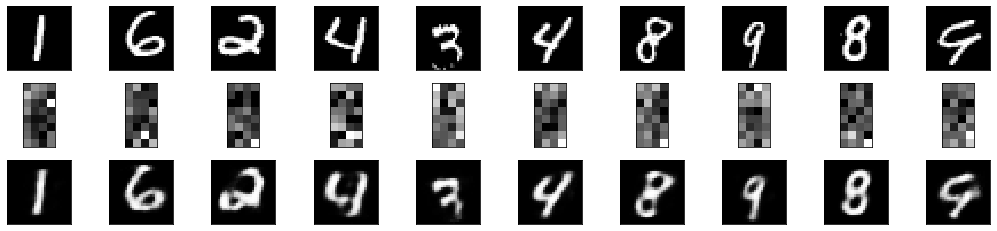

In [11]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***

# Deep Autoencoder


Above, we used single fully-connected layers for both the encoding and decoding models. Instead, we can stack multiple fully-connected layers to make each of the encoder and decoder functions **deep**. You know because deep learning.

In this next model, we'll use 3 fully-connected layers for the encoding model with decreasing dimensions from 128 to 64 32 again. Likewise, we'll add 3 fully-connected decoder layers that reconstruct the image back to 784 dimensions. Except for the last layer, we'll use ReLU activation functions again.

In Keras, this model is painfully simple to do, so let's get started. We'll use the same training configuration: Adam + 50 epochs + batch size of 256.

In [12]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_________________________________________________________________


## Encoder Model

Like we did above, we can extract the encoder model from the autoencoder. The encoder model consists of the first 3 layers in the autoencoder, so let's extract them to visualize the encoded images.

In [13]:
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 108us/sample - loss: 0.2401 - val_loss: 0.1652
Epoch 2/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.1503 - val_loss: 0.1369
Epoch 3/5
60000/60000 [==============================] - 6s 94us/sample - loss: 0.1305 - val_loss: 0.1220
Epoch 4/5
60000/60000 [==============================] - 6s 101us/sample - loss: 0.1199 - val_loss: 0.1150
Epoch 5/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1143 - val_loss: 0.1107


As with the simple autoencoder, we randomly sample 10 test images (the same ones as before). The reconstructed digits look much better than those from the single-layer autoencoder. This observation aligns with the reduction in validation loss after adding multiple layers to the autoencoder.

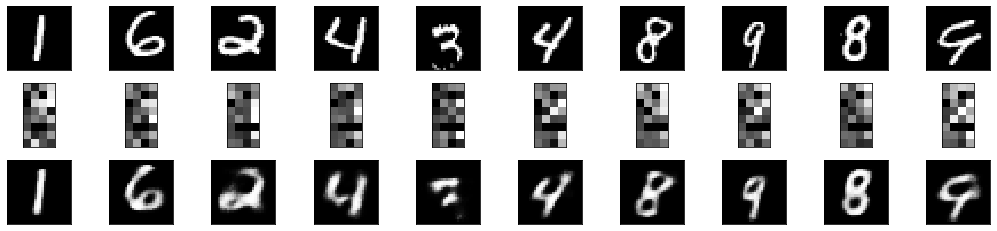

In [15]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***

# Convolutional Autoencoder

Now that we've explored deep autoencoders, let's use a convolutional autoencoder instead, given that the input objects are images. What this means is our encoding and decoding models will be [convolutional neural networks](http://cs231n.github.io/convolutional-networks/) instead of fully-connected networks.

Again, Keras makes this very easy for us. Before we get started though, we need to reshapes the images back to `28 x 28 x 1` for the convnets. The 1 is for 1 channel because black and white. If we had RGB color, there would be 3 channels.

In [16]:
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

To build the convolutional autoencoder, we'll make use of `Conv2D` and `MaxPooling2D` layers for the encoder and `Conv2D` and `UpSampling2D` layers for the decoder. The encoded images are transformed to a 3D array of dimensions `4 x 4 x 8`, but to visualize the encoding, we'll flatten it to a vector of length 128. I tried to use an encoding dimension of 32 like above, but I kept getting subpar results.

After the flattening layer, we reshape the image back to a `4 x 4 x 8` array before upsampling back to a `28 x 28 x 1` image.

In [17]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 8)           0         
__________

## Encoder Model

To extract the encoder model for the autoencoder, we're going to use a slightly different approach than before. Rather than extracting the first 6 layers, we're going to create a new `Model` with the same input as the autoencoder, but the output will be that of the flattening layer. As a side note, this is a very useful technique for grabbing submodels for things like [transfer learning](http://ruder.io/transfer-learning/).

As I mentioned before, the encoded image is a vector of length 128.

In [19]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
Total para

In [21]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=256,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 51s 844us/sample - loss: 32.5201 - val_loss: 30.6281


The reconstructed digits look even better than before. This is no surprise given an even lower validation loss. Other than slight improved reconstruction, check out how the encoded image has changed. What's even cooler is that the encoded images of the 9 look similar as do those of the 8's. This similarity was far less pronounced for the simple and deep autoencoders.

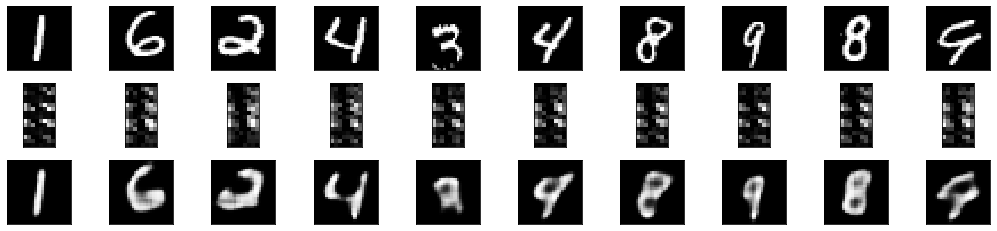

In [22]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Images with the Convolutional Autoencoder

Earlier, I mentioned that autoencoders are useful for denoising data including images. When I learned about this concept in grad school, my mind was blown. This simple task helped me realize data can be manipulated in very useful ways and that the dirty data we often inherit can be cleansed using more advanced techniques.

With that in mind, let's add bit of noise to the test images and see how good the convolutional autoencoder is at removing the noise.

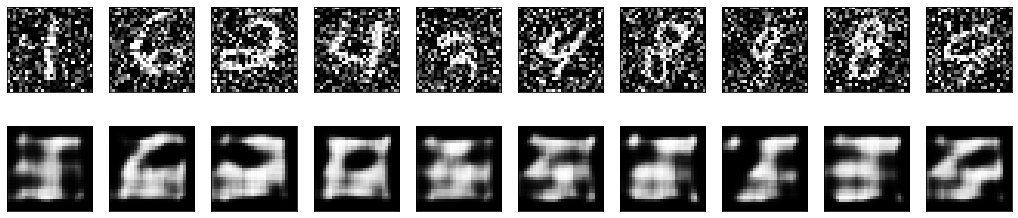

In [23]:
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Autoencoder - Take 2

Okay, so let's try that again. This time we're going to build a ConvNet with a lot more parameters and forego visualizing the encoding layer. The network will be a bit larger and slower to train, but the results are definitely worth the effort.

One more thing: this time, let's use `(x_train_noisy, x_train)` as training data and `(x_test_noisy, x_test)` as validation data.

In [24]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        9248      
__________

In [25]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=1,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 173s 3ms/sample - loss: 21.1768 - val_loss: 14.8557


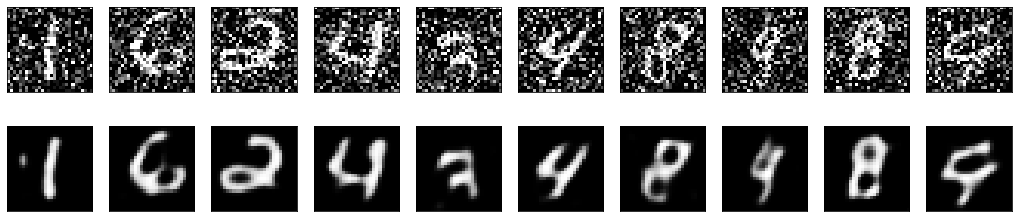

In [26]:
# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fantastic, those images almost look like the originals.